In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import time
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from torchsummary import summary
from collections import deque

from di_dataset3 import DepthImageDataset, collate_batch

from torch.utils.tensorboard import SummaryWriter

2022-03-14 18:43:33.797112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/patricknit/.mujoco/mjpro150/bin
2022-03-14 18:43:33.797128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [3]:
LINUX = True

latent_dim = 64
num_epochs = 250
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False

if LINUX:
    base_path = "/home/patricknit"
else:
    base_path = "/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code"

tfrecord_folder = base_path + "/rl_data/tfrecord_wfiltered"
tfrecord_test_folder = tfrecord_folder + "/test"

save_model_file = base_path + "/vae_models/dronet_final_64"
load_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered_140.pth"

writer = SummaryWriter('runs'+save_model_file[save_model_file.rfind("/"):])

# Load Dataset

In [4]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # 180 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True) # 20 tfrecords

len_train_dataset, len_test_dataset = len(train_dataset), len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

2022-03-14 18:43:34.811554: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-14 18:43:34.811574: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-14 18:43:34.811779: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data173.tfrecords']
Iterating length... 	Done: 57
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data193.tfrecords']
Iterating length... 	Done: 58
57 58


In [5]:
images, images_filtered, *_ = next(iter(train_loader)) # image, filtered image, height, width, depth
images.shape, images_filtered.shape

gotcha


(torch.Size([32, 1, 270, 480]), torch.Size([32, 1, 270, 480]))

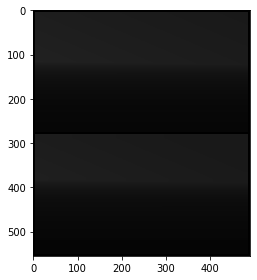

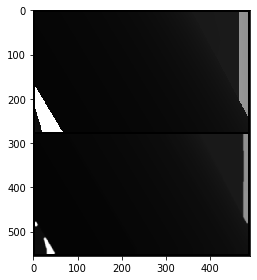

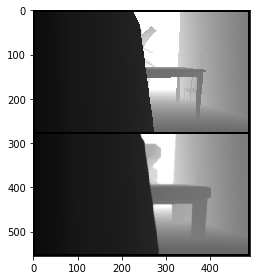

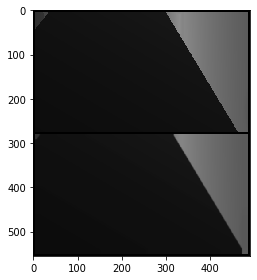

In [6]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

def make_grid_for_tensorboard(images_list, n_grids=2):
    joined_images = []
    [joined_images.extend(images[:n_grids]) for images in images_list]
    return torchvision.utils.make_grid(joined_images, nrow=1, padding=5)

def gridshow(images_list, n_grids=None):
    for n, items in enumerate(zip(*images_list)):
        grid = torchvision.utils.make_grid([*items], nrow=1, padding=5).permute(1, 2, 0)
        imshow(grid)
        if (n+1) == n_grids:
            return

gridshow([images, images_filtered], n_grids=4)
#imshow(make_grid_for_tensorboard([images, images_filtered]).permute(1,2,0))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [7]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs):
        super(Dronet, self).__init__()
        
        print('[Dronet] Starting dronet')

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 64) # Todo: check size
        self.dense1 = nn.Linear(64, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        x1 = self.conv0(img)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)

        # First residual block
        x2 = self.bn0(x1)
        x2 = torch.relu(x2)
        x2 = self.conv1(x2)

        x2 = self.bn1(x2)
        x2 = torch.relu(x2)
        x2 = self.conv2(x2)
        
        x1 = self.conv3(x1)
        x3 = x1+x2

        # Second residual block
        x4 = self.bn2(x3)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)

        x4 = self.bn3(x4)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        
        x3 = self.conv6(x3)
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        x7 = x5+x6 # 17, 30, 128
        
        x = x7.view(x7.size(0), 9*15*128)

        x = torch.relu(x)
        x = self.dense0(x)
        x = torch.relu(x)        
        x_enc = self.dense1(x)
        return x_enc

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

[Dronet] Starting dronet
[Dronet] Done with dronet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      BatchNorm2d-13           [-1, 64, 17, 30]     

### Decoder

In [8]:
class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(16)
        
        self.deconv0 = nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2, padding=2)
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        x = self.dense(z)
        x = x.view(x.size(0), 128, 9, 15)
        
        x = self.deconv1(x)
#         x = self.bn1(x)
        x = torch.relu(x)
        
        x = self.deconv2(x)
#         x = self.bn2(x)
        x = torch.relu(x)
        
        x = self.deconv3(x)
#         x = self.bn3(x)
        x = torch.relu(x)

        x = self.deconv4(x)
#         x = self.bn4(x)
        x = torch.relu(x)

        x = self.deconv5(x)
#         x = self.bn5(x)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
        x = torch.relu(x)
        
        x = self.deconv6(x)
#         x = self.bn6(x)
        x = torch.relu(x)

        x = self.deconv7(x)
        x = torch.sigmoid(x)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1)
summary(img_decoder, (1,latent_dim))

[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 17280]       1,123,200
   ConvTranspose2d-2           [-1, 128, 9, 15]         147,584
   ConvTranspose2d-3           [-1, 64, 17, 30]         204,864
   ConvTranspose2d-4           [-1, 64, 34, 60]         147,520
   ConvTranspose2d-5          [-1, 32, 68, 120]          73,760
   ConvTranspose2d-6         [-1, 32, 135, 240]          25,632
   ConvTranspose2d-7         [-1, 16, 270, 480]          18,448
   ConvTranspose2d-8          [-1, 1, 270, 480]             401
Total params: 1,741,409
Trainable params: 1,741,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 28.22
Params size (MB): 6.64
Estimated Total Size (MB): 34.86
------------------------------

## VAE

In [9]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=n_z*2)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev

        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev

        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        img_recon = self.p_img(z)
        return img_recon


### Define Model

In [10]:
vae_model = VAE(n_z=latent_dim)
writer.add_graph(vae_model, images)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    print(f"Loaded model: {load_model_file}")

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 3

/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/jit/_trace.py:983: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 64, strides=[64, 1], requires_grad=0, device=cpu) = aten::randn_like(%stddev, %523, %524, %525, %526, %527) # /tmp/ipykernel_1878461/3683525493.py:29:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/jit/_trace.py:983: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 3540818 / 4147200 (85.4%)
Greatest absolute difference: 0.0005379021167755127 at index (9, 0, 70, 283) (up to 1e-05 allowed)
Greatest relative difference: 0.0011555952058005003 at index (9, 0, 70, 283) (up to 1e-05 allowed)
  _check_trace

# Training

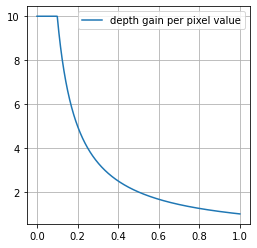

In [11]:
def depth_gain(x):
    return np.minimum(1/(x+0.0001), 10*np.ones_like(x))

x = np.arange(0, 1.001, 0.001)
y = depth_gain(x)

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.grid()
plt.legend(["depth gain per pixel value"])
plt.show()

In [12]:
def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='mean')(x_hat, x) * (270 * 480)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def MSE(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="mean") * (270 * 480)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

def weighted_MSE(x, x_hat, mu, logvar):
    reproduction_loss = (depth_gain(x) * torch.square(x_hat - x)).sum() # Old version, reduce by mean now
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

def filtered_weighted_MSE(filtered_x, x_hat, mu, logvar): 
    reproduction_loss = (depth_gain(filtered_x) * torch.square(x_hat - filtered_x)).mean() * (270 * 480)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

In [ ]:
time_iteration = deque(maxlen=100)
total_train_iterations = 0
total_test_iterations = 0

if load_model:
    start = load_model_file.rfind("_") + 1
    end = load_model_file.rfind(".")
    epoch_start = int("".join([char for char in load_model_file[start:end]]))
    num_epochs = [epoch_start, num_epochs]
else:
    num_epochs = [num_epochs]
    
for epoch in range(*num_epochs):
    # Random file each time
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    train_iterations = len(train_loader)

    test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)
    test_iterations = len(test_loader)
    
    print("Training...")
    vae_model.train()
    running_loss = 0.0
    since = time.time()
    for i, (image, image_filtered, *_) in enumerate(train_loader):
        since_iter = time.time() 
        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = filtered_weighted_MSE(image_filtered, x_hat, mu, logvar)
        running_loss += loss.item()

        # Update weights
        loss.backward()
        optimiser.step()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
    
        # Log info
        writer.add_scalar('training/loss', running_loss/((i+1)*batch_size), global_step=total_train_iterations)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{train_iterations}, Avg. train loss:", \
                  f"{running_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter", \
                  f"{iter_time_mean:.2f}, Est. time left {iter_time_mean*(train_iterations - (i+1)):.2f}")
        if (i+1) % (5) == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('training/images', grid, global_step=total_train_iterations)
            
        total_train_iterations += 1
    
    print("Testing...")
    vae_model.eval()
    test_loss = 0.0
    since = time.time()
    for i, (image, image_filtered, *_) in enumerate(test_loader):
        since_iter = time.time() 
        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = filtered_weighted_MSE(image_filtered, x_hat, mu, logvar)
        test_loss += loss.item()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
    
        # Log info
        writer.add_scalar('test/loss', test_loss/((i+1)*batch_size), global_step=total_test_iterations)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{test_iterations}, Avg. test loss:", \
                  f"{test_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter", \
                  f"{iter_time_mean:.2f}, Est. time left {iter_time_mean*(test_iterations - (i+1)):.2f}")
            
        if (i+1) % (5) == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('test/images', grid, global_step=total_test_iterations)
            
        total_test_iterations += 1
    
    print(f"Epoch: {epoch+1}, Training loss: {running_loss/train_iterations:.3f}, Test loss: {test_loss/test_iterations:.3f}")
    writer.add_scalar('loss_per_epoch/train', running_loss/train_iterations, global_step=epoch)
    writer.add_scalar('loss_per_epoch/test', test_loss/test_iterations, global_step=epoch)

    
    # Save every 10 epochs
    if (epoch+1) % 10 == 0:
        save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
        torch.save(vae_model.state_dict(), save_model_file_dir)
            

Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data77.tfrecords']
Iterating length... 	Done: 64
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data185.tfrecords']
Iterating length... 	Done: 66
Training...
gotcha
Epoch: 1/250, Step: 5/64, Avg. train loss: 1714.803, time: 22.49, Avg. per iter 4.43, Est. time left 261.48
Epoch: 1/250, Step: 10/64, Avg. train loss: 1383.938, time: 44.34, Avg. per iter 4.39, Est. time left 237.27
Epoch: 1/250, Step: 15/64, Avg. train loss: 1190.897, time: 67.39, Avg. per iter 4.46, Est. time left 218.53
Epoch: 1/250, Step: 20/64, Avg. train loss: 1079.817, time: 90.06, Avg. per iter 4.47, Est. time left 196.86
Epoch: 1/250, Step: 25/64, Avg. train loss: 1003.624, time: 112.86, Avg. per iter 4.49, Est. time left 175.02
Epoch: 1/250, Step: 30/64, Avg. train loss: 954.298, time: 134.96, Avg. per iter 4.47, Est. time left 152.08
Epoch: 1/250, Step: 35/64, Avg. train loss: 906.153, time: 157.07, Avg. per iter 4.46, 

Epoch: 3/250, Step: 30/66, Avg. test loss: 516.850, time: 48.24, Avg. per iter 3.10, Est. time left 111.75
Epoch: 3/250, Step: 35/66, Avg. test loss: 517.349, time: 56.19, Avg. per iter 3.10, Est. time left 96.20
Epoch: 3/250, Step: 40/66, Avg. test loss: 512.400, time: 64.15, Avg. per iter 3.05, Est. time left 79.25
Epoch: 3/250, Step: 45/66, Avg. test loss: 509.992, time: 72.04, Avg. per iter 2.92, Est. time left 61.22
Epoch: 3/250, Step: 50/66, Avg. test loss: 512.874, time: 79.97, Avg. per iter 2.79, Est. time left 44.61
Epoch: 3/250, Step: 55/66, Avg. test loss: 506.106, time: 88.22, Avg. per iter 2.66, Est. time left 29.31
Epoch: 3/250, Step: 60/66, Avg. test loss: 508.259, time: 96.18, Avg. per iter 2.54, Est. time left 15.23
Epoch: 3/250, Step: 65/66, Avg. test loss: 503.648, time: 104.12, Avg. per iter 2.41, Est. time left 2.41
Epoch: 3, Training loss: 19053.091, Test loss: 16147.245
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data1.tfrecords']
Iteratin

Epoch: 6/250, Step: 60/61, Avg. train loss: 493.010, time: 244.56, Avg. per iter 3.06, Est. time left 3.06
Testing...
gotcha
Epoch: 6/250, Step: 5/66, Avg. test loss: 457.783, time: 8.43, Avg. per iter 3.08, Est. time left 188.02
Epoch: 6/250, Step: 10/66, Avg. test loss: 440.867, time: 16.78, Avg. per iter 3.09, Est. time left 172.79
Epoch: 6/250, Step: 15/66, Avg. test loss: 447.162, time: 25.02, Avg. per iter 3.09, Est. time left 157.51
Epoch: 6/250, Step: 20/66, Avg. test loss: 439.859, time: 33.14, Avg. per iter 3.09, Est. time left 142.15
Epoch: 6/250, Step: 25/66, Avg. test loss: 433.886, time: 41.28, Avg. per iter 3.09, Est. time left 126.75
Epoch: 6/250, Step: 30/66, Avg. test loss: 436.752, time: 49.35, Avg. per iter 3.09, Est. time left 111.35
Epoch: 6/250, Step: 35/66, Avg. test loss: 435.929, time: 57.19, Avg. per iter 3.09, Est. time left 95.84
Epoch: 6/250, Step: 40/66, Avg. test loss: 433.438, time: 65.11, Avg. per iter 3.07, Est. time left 79.81
Epoch: 6/250, Step: 45/

Epoch: 9/250, Step: 10/67, Avg. train loss: 408.260, time: 42.03, Avg. per iter 2.46, Est. time left 139.95
Epoch: 9/250, Step: 15/67, Avg. train loss: 401.814, time: 62.58, Avg. per iter 2.44, Est. time left 126.77
Epoch: 9/250, Step: 20/67, Avg. train loss: 405.952, time: 83.34, Avg. per iter 2.43, Est. time left 113.98
Epoch: 9/250, Step: 25/67, Avg. train loss: 409.080, time: 103.96, Avg. per iter 2.38, Est. time left 100.00
Epoch: 9/250, Step: 30/67, Avg. train loss: 404.185, time: 124.32, Avg. per iter 2.40, Est. time left 88.90
Epoch: 9/250, Step: 35/67, Avg. train loss: 401.771, time: 144.41, Avg. per iter 2.52, Est. time left 80.56
Epoch: 9/250, Step: 40/67, Avg. train loss: 406.566, time: 164.46, Avg. per iter 2.63, Est. time left 71.02
Epoch: 9/250, Step: 45/67, Avg. train loss: 407.837, time: 184.50, Avg. per iter 2.74, Est. time left 60.37
Epoch: 9/250, Step: 50/67, Avg. train loss: 402.913, time: 204.52, Avg. per iter 2.85, Est. time left 48.48
Epoch: 9/250, Step: 55/67, 

Epoch: 11/250, Step: 45/57, Avg. test loss: 336.206, time: 73.51, Avg. per iter 2.95, Est. time left 35.45
Epoch: 11/250, Step: 50/57, Avg. test loss: 337.066, time: 81.40, Avg. per iter 2.82, Est. time left 19.76
Epoch: 11/250, Step: 55/57, Avg. test loss: 337.225, time: 89.43, Avg. per iter 2.70, Est. time left 5.39
Epoch: 11, Training loss: 12570.888, Test loss: 10784.044
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data56.tfrecords']
Iterating length... 	Done: 65
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data183.tfrecords']
Iterating length... 	Done: 70
Training...
gotcha
Epoch: 12/250, Step: 5/65, Avg. train loss: 330.070, time: 21.56, Avg. per iter 2.65, Est. time left 158.87
Epoch: 12/250, Step: 10/65, Avg. train loss: 337.451, time: 43.16, Avg. per iter 2.66, Est. time left 146.30
Epoch: 12/250, Step: 15/65, Avg. train loss: 346.331, time: 63.91, Avg. per iter 2.66, Est. time left 133.20
Epoch: 12/250, Step: 20/65, Avg. trai

# Evaluation

In [ ]:
load_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered_140.pth"
load_model=False

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))


In [ ]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    images, filtered, *_ = next(iter(test_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # load new tfrecord each time
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()

with torch.no_grad():
    images, filtered, *_ = next(iter(train_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)